# Introduction to Data Science 2025

# Week 6: Recap

## Exercise 1 | Linear regression with feature selection

Download the [TED Talks](https://www.kaggle.com/rounakbanik/ted-talks) dataset from Kaggle. Your task is to predict both the ratings and the number of views of a given TED talk. You should focus only on the <span style="font-weight: bold">ted_main</span> table.

1. Download the data, extract the following ratings from column <span style="font-weight: bold">ratings</span>: <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, <span style="font-weight: bold">Inspiring</span>. Store these values into respective columns so that they are easier to access. Next, extract the tags from column <span style="font-weight: bold">tags</span>. Count the number of occurrences of each tag and select the top-100 most common tags. Create a binary variable for each of these and include them in your data table, so that you can directly see whether a given tag (among the top-100 tags) is used in a given TED talk or not. The dataset you compose should have dimension (2550, 104), and comprise of the 'views' column, the three columns with counts of "Funny", "Confusing and "Inspiring" ratings, and 100 columns which one-hot encode the top-100 most common tag columns.


In [ ]:
import pandas as pd,ast
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LassoCV
import numpy as np
from math import sqrt

df=pd.read_csv("ted_main.csv")
def rc(s,n):
    try:
        r=ast.literal_eval(s)
        for i in r:
            if i["name"]==n:return i["count"]
    except:return 0
    return 0
df["Funny"]=df["ratings"].apply(lambda x:rc(x,"Funny"))
df["Confusing"]=df["ratings"].apply(lambda x:rc(x,"Confusing"))
df["Inspiring"]=df["ratings"].apply(lambda x:rc(x,"Inspiring"))
df["tag_list"]=df["tags"].apply(lambda x:ast.literal_eval(x))
tags=[t for l in df["tag_list"] for t in l]
top=[t for t,_ in Counter(tags).most_common(100)]
for t in top:df[t]=df["tag_list"].apply(lambda x:int(t in x))
cols=["views","Funny","Confusing","Inspiring"]+top
data=df[cols]
print(data.shape)
print(data.head())


(2550, 104)
      views  Funny  Confusing  Inspiring  technology  science  global issues  \
0  47227110  19645        242      24924           0        0              0   
1   3200520    544         62        413           1        1              1   
2   1636292    964         27        230           1        0              0   
3   1697550     59         32       1070           0        0              0   
4  12005869   1390         72       2893           0        0              1   

   culture  TEDx  design  ...  food  religion  peace  ecology  family  demo  \
0        1     0       0  ...     0         0      0        0       0     0   
1        1     0       0  ...     0         0      0        0       0     0   
2        0     0       0  ...     0         0      0        0       0     0   
3        0     0       0  ...     0         0      0        0       0     0   
4        0     0       0  ...     0         0      0        0       0     1   

   poetry  illness  universe  en

/tmp/ipykernel_11953/4086323707.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  for t in top:df[t]=df["tag_list"].apply(lambda x:int(t in x))
/tmp/ipykernel_11953/4086323707.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  for t in top:df[t]=df["tag_list"].apply(lambda x:int(t in x))
/tmp/ipykernel_11953/4086323707.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

2. Construct a linear regression model to predict the number of views based on the data in the <span style="font-weight: bold">ted_main</span> table, including the binary variables for the top-100 tags that you just created.

In [33]:
X=data.drop("views",axis=1)
y=data["views"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
model=LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("R2:",r2_score(y_test,y_pred))
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)))

R2: 0.674946955213626
RMSE: 1123480.1881770883


3. Do the same for the <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, and <span style="font-weight: bold">Inspiring</span> ratings.

In [34]:
targets=["Funny","Confusing","Inspiring"]
for t in targets:
    X=data.drop(["views","Funny","Confusing","Inspiring"],axis=1)
    y=data[t]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    model=LinearRegression()
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print(t,"R2:",r2_score(y_test,y_pred),"RMSE:",sqrt(mean_squared_error(y_test,y_pred)))


Funny R2: 0.2093054993393716 RMSE: 325.8434805509552
Confusing R2: 0.18953655784818524 RMSE: 27.08909130838316
Inspiring R2: 0.07712709702403364 RMSE: 920.5725868105574


4. You will probably notice that most of the tags are not useful in predicting the views and the ratings. You should use some kind of variable selection to prune the set of tags that are included in the model. You can use for example classical p-values or more modern [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) techniques. Which tags are the best predictors of each of the response variables?

In [35]:
X_full=data.drop(["views","Funny","Confusing","Inspiring"],axis=1)
y_vars={"views":data["views"],"Funny":data["Funny"],"Confusing":data["Confusing"],"Inspiring":data["Inspiring"]}
for name,y in y_vars.items():
    model=LassoCV(cv=5,random_state=42).fit(X_full,y)
    coef=pd.Series(model.coef_,index=X_full.columns)
    best=coef[coef!=0].sort_values(key=np.abs,ascending=False)
    print(name,"best predictors:")
    print(best.head(10))
    print()

views best predictors:
psychology       1.547282e+06
work             7.895974e+05
motivation       5.747320e+05
culture          5.642394e+05
brain            4.908181e+05
demo             4.324695e+05
global issues   -4.017183e+05
art             -3.137049e+05
humor            2.986529e+05
education        2.924200e+05
dtype: float64

Funny best predictors:
humor            713.548145
entertainment    123.734510
psychology       119.639214
work             110.651055
culture          110.321882
creativity        97.136023
education         73.676552
children          58.942449
global issues    -58.422355
design           -40.382740
dtype: float64

Confusing best predictors:
evolution     16.194700
philosophy    15.329317
religion      12.876535
physics       12.636914
psychology    11.316561
brain         10.874812
culture        9.024819
math           8.802251
animals       -6.511811
Africa        -6.244186
dtype: float64

Inspiring best predictors:
psychology       694.919514
work

5. Produce summaries of your results. Could you recommend good tags – or tags to avoid! – for speakers targeting plenty of views and/or certain ratings?

In [ ]:
X=data.drop(["views","Funny","Confusing","Inspiring"],axis=1)
y_vars={"views":data["views"],"Funny":data["Funny"],"Confusing":data["Confusing"],"Inspiring":data["Inspiring"]}
results={}
for name,y in y_vars.items():
    model=LassoCV(cv=5,random_state=42).fit(X,y)
    coef=pd.Series(model.coef_,index=X.columns)
    selected=coef[coef!=0].sort_values()
    results[name]=selected
    print(f"\n{name} — top positive predictors:")
    print(selected.tail(10))
    print(f"\n{name} — top negative predictors:")
    print(selected.head(10))

#Increase views: psychology, work, motivation, culture, brain, demo, humor, education, business, mental health
#Decrease views: global issues, art, design, politics, economics, health care, war, science, activism, technology


views — top positive predictors:
mental health    2.585914e+05
business         2.702778e+05
education        2.924200e+05
humor            2.986529e+05
demo             4.324695e+05
brain            4.908181e+05
culture          5.642394e+05
motivation       5.747320e+05
work             7.895974e+05
psychology       1.547282e+06
dtype: float64

views — top negative predictors:
global issues   -401718.250775
art             -313704.926421
design          -266147.634624
politics        -236657.383932
economics       -226233.810284
health care     -167041.280598
war             -159669.057536
science         -159247.114933
activism        -153037.447722
technology      -142141.789857
dtype: float64

Funny — top positive predictors:
motivation         1.093644
happiness         20.567568
children          58.942449
education         73.676552
creativity        97.136023
culture          110.321882
work             110.651055
psychology       119.639214
entertainment    123.734510
humor 

**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 2 | Symbol classification (part 2)

Note that it is strongly recommended to use Python in this exercise. However, if you can find a suitable AutoML implementation for your favorite language (e.g [here](http://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/automl.html) seems to be one for R) then you are free to use that language as well.

Use the preprocessed data from week 3 (you can also produce them using the example solutions of week 3).

1. This time train a *random forest classifier* on the data. A random forest is a collection of *decision trees*, which makes it an *ensemble* of classifiers. Each tree uses a random subset of the features to make its prediction. Without tuning any parameters, how is the accuracy?

X_train shape: (816, 1024)
y_train shape: (816,)
X_test shape: (204, 1024)
y_test shape: (204,)
Random Forest accuracy: 0.8627450980392157


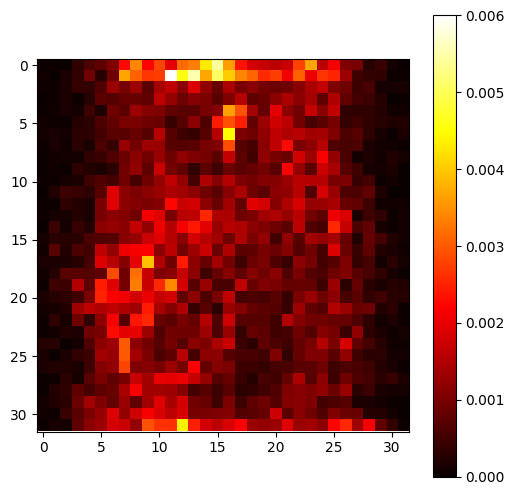

In [37]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Random Forest accuracy:", acc)

importances = rf.feature_importances_.reshape(32, 32)
plt.figure(figsize=(6,6))
plt.imshow(importances, cmap="hot")
plt.colorbar()
plt.show()

2. The amount of trees to use as a part of the random forest is an example of a hyperparameter, because it is a parameter that is set prior to the learning process. In contrast, a parameter is a value in the model that is learned from the data. Train 20 classifiers, with varying amounts of decision trees starting from 10 up until 200, and plot the test accuracy as a function of the amount of classifiers. Does the accuracy keep increasing? Is more better?

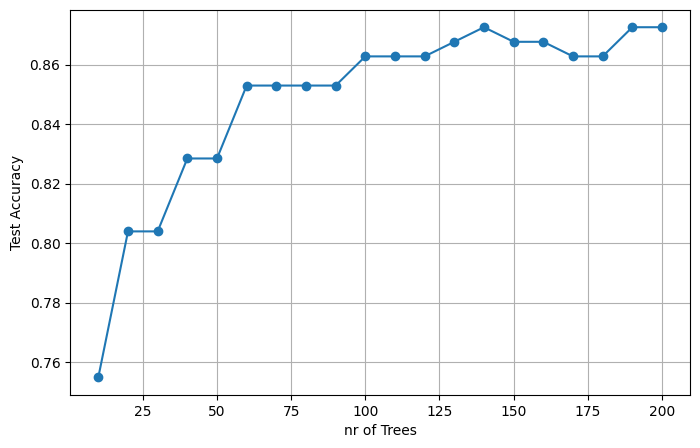

In [38]:
n_trees = np.linspace(10, 200, 20, dtype=int)
accs = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(8,5))
plt.plot(n_trees, accs, marker='o')
plt.xlabel("nr of Trees")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


3. If we had picked the amount of decision trees by taking the value with the best test accuracy from the last plot, we would have *overfit* our hyperparameters to the test data. Can you see why it is a mistake to tune hyperparameters of your model by using the test data?

Tuning hyperparameters using the test data is a mistake because it biases the model to that specific test set giving an overoptimistic estimate of performance. The test set should only be used once at the end to evaluate the final model and hyperparameters should be selected using a separate validation set.

4. Reshuffle and resplit the data so that it is divided in 3 parts: training (80%), validation (10%) and test (10%). Repeatedly train a model of your choosing (e.g random forest) on the training data, and evaluate it’s performance on the validation set, while tuning the hyperparameters so that the accuracy on the validation set increases. Then, finally evaluate the performance of your model on the test data. What can you say in terms of the generalization of your model?

In [42]:
X_full = np.vstack([X_train, X_test])
y_full = np.hstack([y_train, y_test])

X_temp, X_final_test, y_temp, y_final_test = train_test_split(X_full, y_full, test_size=0.1, random_state=42)
X_final_train, X_val, y_final_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42)

best_acc = 0
best_model = None

for n_trees in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_final_train, y_final_train)
    val_acc = accuracy_score(y_val, rf.predict(X_val))
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = rf

test_acc = accuracy_score(y_final_test, best_model.predict(X_final_test))
print("Validation accuracy:", best_acc)
print("Test accuracy:", test_acc)

Validation accuracy: 0.8529411764705882
Test accuracy: 0.8823529411764706


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 3 | TPOT

The process of picking a suitable model, evaluating its performance and tuning the hyperparameters is very time consuming. A new idea in machine learning is the concept of automating this by using an optimization algorithm to find the best model in the space of models and their hyperparameters. Have a look at [TPOT](https://github.com/EpistasisLab/tpot), an automated ML solution that finds a good model and a good set of hyperparameters automatically. Try it on this data, it should outperform simple models like the ones we tried easily. Note that running the algorithm might take a while, depending on the strength of your computer. 

*Note*: In case it is running for too long, try checking if the parameters you are using when calling TPOT are reasonable, i.e. try reducing number of ‘generations’ or ‘population_size’. TPOT uses cross-validation internally, so we don’t need our own validation set.

In [ ]:
from tpot import TPOTClassifier
from sklearn.metrics import accuracy_score

tpot = TPOTClassifier(generations=5, population_size=20, random_state=42)
tpot.fit(X_train, y_train)

y_pred = tpot.predict(X_test)
print("TPOT test accuracy:", accuracy_score(y_test, y_pred))

with open("tpot.py", "w") as f:
    f.write(tpot.fitted_pipeline_.__repr__())


/home/pniki/Desktop/wk6/.venv/lib/python3.10/site-packages/tpot/tpot_estimator/estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
/home/pniki/Desktop/wk6/.venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41427 instead
  warnings.warn(
/home/pniki/Desktop/wk6/.venv/lib/python3.10/site-packages/tpot/tpot_estimator/estimator.py:537: UserWarning: Labels are not encoded as ints from 0 to N. For compatibility with some classifiers such as sklearn, TPOT has encoded y with the sklearn LabelEncoder. When using pipelines outside the main TPOT estimator class, you can encode the labels with est.label_encoder_
  warnings.warn("Labels are not encoded as ints from 0 to N. For compatib

TPOT test accuracy: 0.0


AttributeError: 'TPOTClassifier' object has no attribute 'export'

**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**